# Image Classification with MLPs - Lab

## Introduction

For the final lab in this section, we'll build a more advanced **_Multi-Layer Perceptron_** to solve image classification for a classic dataset, MNIST!  This dataset consists of thousands of labeled images of handwritten digits, and it has a special place in the history of Deep Learning. 

## Objectives 

- Build a multi-layer neural network image classifier using Keras 

## Packages

First, let's import all the classes and packages you'll need for this lab.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist

Using TensorFlow backend.
/home/a00005987/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.21.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


##  Data 

Before we get into building the model, let's load our data and take a look at a sample image and label. 

The MNIST dataset is often used for benchmarking model performance in the world of AI/Deep Learning research. Because it's commonly used, Keras actually includes a helper function to load the data and labels from MNIST -- it even loads the data in a format already split into training and test sets!

Run the cell below to load the MNIST dataset. Note that if this is the first time you are working with MNIST through Keras, this will take a few minutes while Keras downloads the data. 

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11476992/11490434 [============================>.] - ETA: 0s

Great!  

Now, let's quickly take a look at an image from the MNIST dataset -- we can visualize it using Matplotlib. Run the cell below to visualize the first image and its corresponding label. 

Label: 5


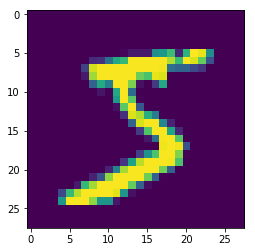

In [3]:
sample_image = X_train[0]
sample_label = y_train[0]
display(plt.imshow(sample_image))
print('Label: {}'.format(sample_label))

Great! That was easy. Now, we'll see that preprocessing image data has a few extra steps in order to get it into a shape where an MLP can work with it. 

## Preprocessing Images For Use With MLPs

By definition, images are matrices -- they are a spreadsheet of pixel values between 0 and 255. We can see this easily enough by just looking at a raw image:

In [4]:
sample_image

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

This is a problem in its current format, because MLPs take their input as vectors, not matrices or tensors. If all of the images were different sizes, then we would have a more significant problem on our hands, because we'd have challenges getting each image reshaped into a vector the exact same size as our input layer. However, this isn't a problem with MNIST, because all images are black white 28x28 pixel images. This means that we can just concatenate each row (or column) into a single 784-dimensional vector! Since each image will be concatenated in the exact same way, positional information is still preserved (e.g. the pixel value for the second pixel in the second row of an image will always be element number 29 in the vector). 

Let's get started. In the cell below, print the `.shape` of both `X_train` and `X_test`

In [5]:
print(X_train.shape)
X_test.shape

(60000, 28, 28)


(10000, 28, 28)

We can interpret these numbers as saying "`X_train` consists of 60,000 images that are 28x28". We'll need to reshape them from `(28, 28)`, a 28x28 matrix, to `(784,)`, a 784-element vector. However, we need to make sure that the first number in our reshape call for both `X_train` and `X_test` still correspond to the number of observations we have in each. 

In the cell below:

* Use the `.reshape()` method to reshape `X_train`. The first parameter should be `60000`, and the second parameter should be `784` 
* Similarly, reshape `X_test` to `10000` and `784`  
* Also, chain both `.reshape()` calls with an `.astype('float32')`, so that we convert our data from type `uint8` to `float32` 

In [6]:
X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')

Now, let's check the shape of our training and test data again to see if it worked. 

In [7]:
print(X_train.shape)
X_test.shape

(60000, 784)


(10000, 784)

Great! Now, we just need to normalize our data!

## Normalizing Image Data

Since all pixel values will always be between 0 and 255, we can just scale our data by dividing every element by 255! Run the cell below to do so now. 

In [8]:
X_train /= 255.
X_test /= 255.

Great! We've now finished preprocessing our image data. However, we still need to deal with our labels. 

## Preprocessing our Labels

Let's take a quick look at the first 10 labels in our training data:

In [9]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

As we can see, the labels for each digit image in the training set are stored as the corresponding integer value -- if the image is of a 5, then the corresponding label will be `5`. This means that this is a **_Multiclass Classification_** problem, which means that we need to **_One-Hot Encode_** our labels before we can use them for training. 

Luckily, Keras provides a really easy utility function to handle this for us. 

In the cell below: 

* Use the function `to_categorical()` to one-hot encode our labels. This function can be found in the `keras.utils` sub-module. Pass in the following parameters:
    * The object we want to one-hot encode, which will be `y_train`/`y_test` 
    * The number of classes contained in the labels, `10` 

In [10]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

Great. Now, let's examine the label for the first data point, which we saw was `5` before. 

In [11]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

Perfect! As we can see, the fifth index is set to `1`, while everything else is set to `0`. That was easy!  Now, let's get to the fun part -- building our model!

## Building our Model

For the remainder of this lab, we won't hold your hand as much -- flex your newfound Keras muscles and build an MLP with the following specifications:

* A `Dense` hidden layer with `64` neurons, and a `'tanh'` activation function. Also, since this is the first hidden layer, be sure to pass in `input_shape=(784,)` in order to create a correctly-sized input layer!
* Since this is a multiclass classification problem, our output layer will need to be a `Dense` layer where the number of neurons is the same as the number of classes in the labels. Also, be sure to set the activation function to `'softmax'` 

In [12]:
model_1 = Sequential()
model_1.add(Dense(64, activation='tanh', input_shape=(784,)))
model_1.add(Dense(10, activation='softmax'))

Now, compile your model with the following parameters:

* `loss='categorical_crossentropy'`
* `optimizer='sgd'`
* `metrics = ['accuracy']`

In [13]:
model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Let's quickly inspect the shape of our model before training it and see how many training parameters we have. In the cell below, call the model's `.summary()` method. 

In [14]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


50,890 trainable parameters! Note that while this may seem large, deep neural networks in production may have hundreds or thousands of layers and many millions of trainable parameters!

Let's get on to training. In the cell below, fit the model. Use the following parameters:

* Our training data and labels
* `epochs=5`
* `batch_size=64`
* `validation_data=(X_test, y_test)`

In [15]:
results_1 = model_1.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s - loss: 0.8414 - acc: 0.7952 - val_loss: 0.4892 - val_acc: 0.8783
Epoch 2/5
60000/60000 [==============================] - 1s - loss: 0.4468 - acc: 0.8835 - val_loss: 0.3833 - val_acc: 0.8978
Epoch 3/5
60000/60000 [==============================] - 1s - loss: 0.3771 - acc: 0.8966 - val_loss: 0.3394 - val_acc: 0.9069
Epoch 4/5
60000/60000 [==============================] - 1s - loss: 0.3417 - acc: 0.9047 - val_loss: 0.3143 - val_acc: 0.9131
Epoch 5/5
60000/60000 [==============================] - 1s - loss: 0.3186 - acc: 0.9105 - val_loss: 0.2969 - val_acc: 0.9162


## Visualizing our Loss and Accuracy Curves

Now, let's inspect the model's performance and see if we detect any overfitting or other issues. In the cell below, create two plots:

* The `loss` and `val_loss` over the training epochs
* The `acc` and `val_acc` over the training epochs

**_HINT:_** Consider copying over the visualization function from the previous lab in order to save time!

In [16]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

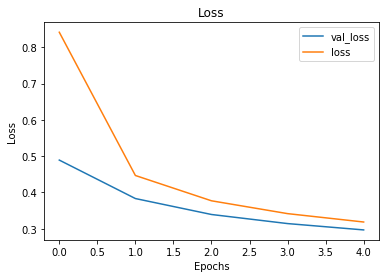

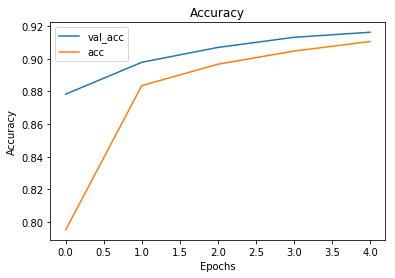

In [17]:
visualize_training_results(results_1)

Pretty good! Note that since our validation scores are currently higher than our training scores, its extremely unlikely that our model is overfitting to the training data. This is a good sign -- that means that we can probably trust the results that our model is ~91.7% accurate at classifying handwritten digits!

## Building a Bigger Model

Now, let's add another hidden layer and see how this changes things. In the cells below, create a second model. This model should have the following architecture:

* Input layer and first hidden layer same as `model_1`
* Another `Dense` hidden layer, this time with `32` neurons and a `'tanh'` activation function
* An output layer same as `model_1` 

In [18]:
model_2 = Sequential()
model_2.add(Dense(64, activation='tanh', input_shape=(784,)))
model_2.add(Dense(32, activation='tanh'))
model_2.add(Dense(10, activation='softmax'))

Let's quickly inspect the `.summary()` of the model again, to see how many new trainable parameters this extra hidden layer has introduced.

In [19]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


This model isn't much bigger, but the layout means that the 2080 parameters in the new hidden layer will be focused on higher layers of abstraction than the first hidden layer. Let's see how it compares after training. 

In the cells below, compile and fit the model using the same parameters you did for `model_1`.

In [20]:
model_2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [21]:
results_2 = model_2.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s - loss: 0.9062 - acc: 0.7834 - val_loss: 0.5239 - val_acc: 0.8775
Epoch 2/5
60000/60000 [==============================] - 1s - loss: 0.4552 - acc: 0.8847 - val_loss: 0.3834 - val_acc: 0.9004
Epoch 3/5
60000/60000 [==============================] - 1s - loss: 0.3653 - acc: 0.9018 - val_loss: 0.3289 - val_acc: 0.9096
Epoch 4/5
60000/60000 [==============================] - 1s - loss: 0.3229 - acc: 0.9106 - val_loss: 0.3005 - val_acc: 0.9157
Epoch 5/5
60000/60000 [==============================] - 1s - loss: 0.2960 - acc: 0.9168 - val_loss: 0.2792 - val_acc: 0.9209


Now, visualize the plots again. 

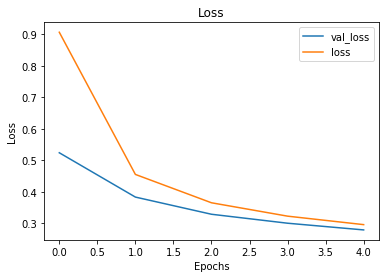

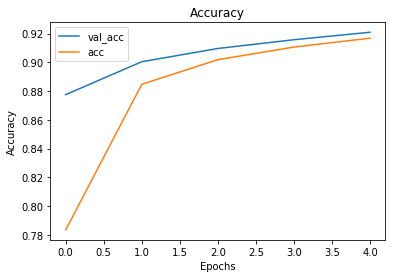

In [22]:
visualize_training_results(results_2)

Slightly better validation accuracy, with no evidence of overfitting -- great! If you run the model for more epochs, you'll see the model's performance continues to improve until the validation metrics plateau and the model begins to overfit to training data. 

## A Bit of Tuning

As a final exercise, let's see what happens to the model's performance if we switch activation functions from `'tanh'` to `'relu'`. In the cell below, recreate  `model_2`, but replace all `'tanh'` activations with `'relu'`. Then, compile, train, and plot the results using the same parameters as the other two. 

In [23]:
model_3 = Sequential()
model_3.add(Dense(64, activation='relu', input_shape=(784,)))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(10, activation='softmax'))

In [24]:
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [26]:
results_3 = model_3.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s - loss: 0.9726 - acc: 0.7359 - val_loss: 0.4315 - val_acc: 0.8796
Epoch 2/5
60000/60000 [==============================] - 1s - loss: 0.3913 - acc: 0.8896 - val_loss: 0.3251 - val_acc: 0.9109
Epoch 3/5
60000/60000 [==============================] - 1s - loss: 0.3219 - acc: 0.9086 - val_loss: 0.2866 - val_acc: 0.9190
Epoch 4/5
60000/60000 [==============================] - 1s - loss: 0.2847 - acc: 0.9191 - val_loss: 0.2559 - val_acc: 0.9260
Epoch 5/5
60000/60000 [==============================] - 1s - loss: 0.2578 - acc: 0.9267 - val_loss: 0.2375 - val_acc: 0.9320


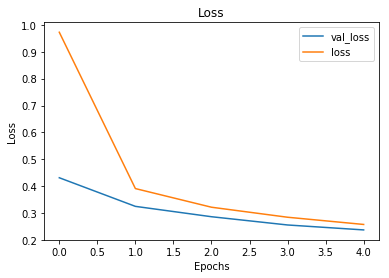

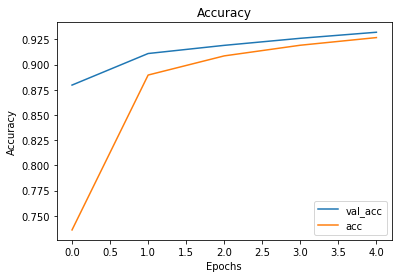

In [27]:
visualize_training_results(results_3)

Performance improved even further! ReLU is one of the most commonly used activation functions around right now -- it's especially useful in computer vision problems like image classification, as we've just seen. 

## Summary

In this lab, you once again practiced and reviewed the process of building a neural network. This time, you built a more complex network with additional layers which improved the performance of your model on the MNIST dataset! 